# Model and dataset used:
- SiEBERT: https://huggingface.co/siebert/sentiment-roberta-large-english/discussions
- amazon_polarity: https://huggingface.co/datasets/amazon_polarity

by: Alyosha Romanov (romanov2)

In [1]:
import os
import torch
import random
import numpy as np

if torch.cuda.is_available():
    device = torch.device("cuda")
    vram_total = torch.cuda.get_device_properties(0).total_memory
    vram_total_gb = vram_total / (1024 ** 3)
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"Total VRAM: {vram_total_gb:.2f} GB")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(f"Random seed set as {seed}")

Using GPU: NVIDIA GeForce RTX 3080 Ti Laptop GPU
Total VRAM: 16.00 GB
Random seed set as 42


In [2]:
#basic setup
model_name = "siebert/sentiment-roberta-large-english"
dataset_name = "amazon_polarity"
subset_test = 1 / 5000
subset_train = 1 / 100

#training
model_output = "./model"
output_dir="./results"
epochs = 3
batch_size = 8
warmup_steps = 30
weight_decay = 0.01
logging_steps = 10

In [3]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [4]:
from datasets import load_dataset

dataset = load_dataset(dataset_name)

train_size = int(subset_test * len(dataset['train']))
test_size = int(subset_train * len(dataset['test']))

train_dataset = dataset['train'].shuffle(seed=seed).select(range(train_size))
test_dataset = dataset['test'].shuffle(seed=seed).select(range(test_size))

Found cached dataset amazon_polarity (C:/Users/alyosharomanov/.cache/huggingface/datasets/amazon_polarity/amazon_polarity/3.0.0/a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\alyosharomanov\.cache\huggingface\datasets\amazon_polarity\amazon_polarity\3.0.0\a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc\cache-136155fe6e7a2382.arrow
Loading cached shuffled indices for dataset at C:\Users\alyosharomanov\.cache\huggingface\datasets\amazon_polarity\amazon_polarity\3.0.0\a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc\cache-0a5d0b47b5e8dfc6.arrow


In [5]:
def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True)


tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\alyosharomanov\.cache\huggingface\datasets\amazon_polarity\amazon_polarity\3.0.0\a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc\cache-a1e9e7ffe8db5338.arrow
Loading cached processed dataset at C:\Users\alyosharomanov\.cache\huggingface\datasets\amazon_polarity\amazon_polarity\3.0.0\a27b32b7e7b88eb274a8fa8ba0f654f1fe998a87c22547557317793b5d2772dc\cache-57ae315201a9132a.arrow


# Training

In [6]:
from transformers import Trainer, TrainingArguments

torch.cuda.empty_cache()

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_steps=logging_steps,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test
)

trainer.train()

Step,Training Loss
10,0.375600
20,0.366500
30,0.122000
40,0.409000
50,0.283400
60,0.302100
70,0.136600
80,0.266500
90,0.490800
100,0.444600


TrainOutput(global_step=270, training_loss=0.22501769468740182, metrics={'train_runtime': 2206.3939, 'train_samples_per_second': 0.979, 'train_steps_per_second': 0.122, 'total_flos': 2012971744788480.0, 'train_loss': 0.22501769468740182, 'epoch': 3.0})

In [7]:
model.save_pretrained(model_output)
tokenizer.save_pretrained(model_output)

('./model\\tokenizer_config.json',
 './model\\special_tokens_map.json',
 './model\\vocab.json',
 './model\\merges.txt',
 './model\\added_tokens.json',
 './model\\tokenizer.json')

# Testing

In [8]:
from transformers import pipeline

original_pipeline = pipeline("sentiment-analysis", model=model_name, return_all_scores=True)
fine_tuned_pipeline = pipeline("sentiment-analysis", model=model_output, return_all_scores=True)

C:\Users\alyosharomanov\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [9]:
print(fine_tuned_pipeline("so good!"))
print(fine_tuned_pipeline("so bad..."))

[[{'label': 'NEGATIVE', 'score': 0.0009206280228681862}, {'label': 'POSITIVE', 'score': 0.9990793466567993}]]
[[{'label': 'NEGATIVE', 'score': 0.9953475594520569}, {'label': 'POSITIVE', 'score': 0.004652450792491436}]]


In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

def evaluate_pipeline(pipeline, test_dataset):
    predictions, true_labels = [], []

    for example in tqdm(test_dataset, desc=f"Evaluating"):
        outputs = pipeline(example["content"])
        negative_score, positive_score = outputs[0][0]['score'], outputs[0][1]['score']
        pred_label = 1 if positive_score > negative_score else 0
        predictions.append(pred_label)
        true_labels.append(example['label'])

    return predictions, true_labels

original_predictions, original_true_labels = evaluate_pipeline(original_pipeline, test_dataset)
fine_tuned_predictions, fine_tuned_true_labels = evaluate_pipeline(fine_tuned_pipeline, test_dataset)

Evaluating: 100%|██████████| 4000/4000 [20:00<00:00,  3.33it/s]


### Orginal

In [11]:
precision = precision_score(original_predictions, original_true_labels, average='binary')
recall = recall_score(original_predictions, original_true_labels, average='binary')
f1score = f1_score(original_predictions, original_true_labels, average='binary')

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.9661432777232581
Recall = 0.9484585741811176
F1 Score = 0.9572192513368984


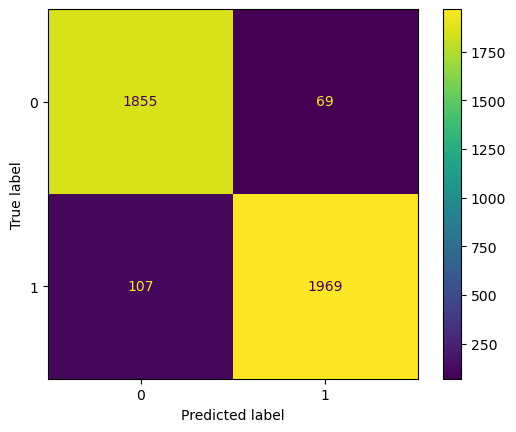

In [12]:
confusion_matrix = metrics.confusion_matrix(original_predictions, original_true_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()

### New Model

In [13]:
precision = precision_score(fine_tuned_predictions, fine_tuned_true_labels, average='binary')
recall = recall_score(fine_tuned_predictions, fine_tuned_true_labels, average='binary')
f1score = f1_score(fine_tuned_predictions, fine_tuned_true_labels, average='binary')

print(f"Precision = {precision}")
print(f"Recall = {recall}")
print(f"F1 Score = {f1score}")

Precision = 0.9376840039254171
Recall = 0.9641775983854692
F1 Score = 0.9507462686567164


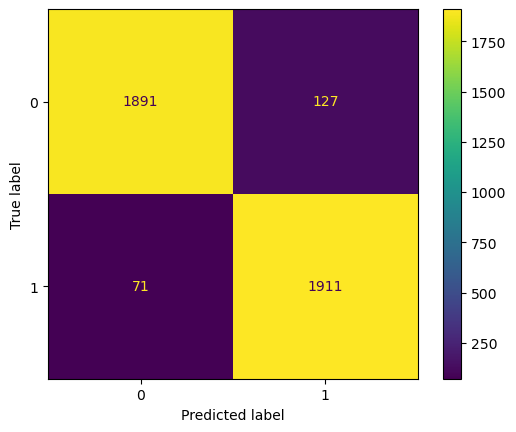

In [14]:
confusion_matrix = metrics.confusion_matrix(fine_tuned_predictions, fine_tuned_true_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0, 1])
cm_display.plot()
plt.show()